# Structuring The Dataset

In [ ]:
from PIL import Image
import numpy as np
import os
import cv2
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [ ]:
data=[]

parasitized=os.listdir("./cell_images/Parasitized/")
for par in parasitized:
    try:
        image=cv2.imread("./cell_images/Parasitized/" + par)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((100, 100))
        data.append(np.array(size_image))
    except AttributeError:
        print("Skipped one in parasitized")

uninfected=os.listdir("./cell_images/Uninfected/")
for uninfec in uninfected:
    try:
        image=cv2.imread("./cell_images/Uninfected/" + uninfec)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((100, 100))
        data.append(np.array(size_image))
    except AttributeError:
        print("Skipped one in uninfected")

labels = np.concatenate((np.zeros(len(parasitized)), np.ones(len(uninfected))), axis=0)

cells = np.array(data)

Skipped one in parasitized
Skipped one in uninfected


In [ ]:
# verifying lengths
print(f'len(parasitized):\t{len(parasitized)}')
print(f'len(uninfected):\t{len(uninfected)}')
print(f'len(cells):\t\t{len(cells)}')
print(f'len(data):\t\t{len(data)}')

len(parasitized):	13780
len(uninfected):	13780
len(cells):		27558
len(data):		27558


In [ ]:
# shuffling data to get ready for split
shuffle = np.arange(cells.shape[0])
np.random.shuffle(shuffle)
cells = cells[shuffle]
labels = labels[shuffle]

In [ ]:
# splitting data into train, test and validation sets (manually)
x_train, x_test, x_val = cells[:25000], cells[25000:27500], cells[27500:]
y_train, y_test, y_val = labels[:25000], labels[25000:27500], labels[27500:]

In [ ]:
# verifying even distribution of data
print("\t0's\t1's")
print(f'y_train\t{np.count_nonzero(y_train == 0)}\t{np.count_nonzero(y_train == 1)}')
print(f'y_test\t{np.count_nonzero(y_test == 0)}\t{np.count_nonzero(y_test == 1)}')
print(f'y_val\t{np.count_nonzero(y_val == 0)}\t{np.count_nonzero(y_val == 1)}')

	0's	1's
y_train	12530	12470
y_test	1224	1276
y_val	26	32


# Training The Model

In [ ]:
# data augmentation to reduce variance
datagen = ImageDataGenerator(
        rotation_range = 30,    # rotate images in the range 30 degrees
        zoom_range = 0.2,       # zoom image
        width_shift_range=0.1,  # shift images horizontally (fraction of total width)
        height_shift_range=0.1, # shift images vertically (fraction of total height)
        horizontal_flip = True, # flip images
        )

In [ ]:
# dense layer 1 and 2 have 512 neurons instead of 4096 neurons in the standard AlexNet architecture,
# due to low availible input size of images --> 100, 100, 3 (recommended size for AlexNet --> 227, 227, 3)

alexnet = tf.keras.models.Sequential([
    # convolution 1
    Conv2D(96, (11,11),strides=(4,4), activation='relu', input_shape=(100, 100, 3)),
    BatchNormalization(),
    MaxPooling2D(),
    # convolution 2
    Conv2D(256, (5,5),strides=(1,1), activation='relu',padding="same"),
    BatchNormalization(),
    MaxPooling2D(),
    # convolution 3
    Conv2D(384, (3,3),strides=(1,1), activation='relu',padding="same"),
    BatchNormalization(),
    # convolution 4
    Conv2D(384, (3,3),strides=(1,1), activation='relu',padding="same"),
    BatchNormalization(),
    # convolution 5
    Conv2D(256, (3, 3), strides=(1, 1), activation='relu',padding="same"),
    BatchNormalization(),
    MaxPooling2D(),
    # flattening
    Flatten(),
    # dense layer 1
    Dense(512, activation='relu'),
    Dropout(0.5),
    # dense layer 2
    Dense(512, activation='relu'),
    Dropout(0.5),
    # output neuron
    Dense(1, activation='sigmoid')
])

alexnet.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 23, 23, 96)        34944     
_________________________________________________________________
batch_normalization_5 (Batch (None, 23, 23, 96)        384       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 11, 11, 96)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 11, 11, 256)       614656    
_________________________________________________________________
batch_normalization_6 (Batch (None, 11, 11, 256)       1024      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 256)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 5, 5, 384)        

In [ ]:
alexnet.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [ ]:
# training the model
history = alexnet.fit(
    datagen.flow(x_train, y_train, batch_size = 64),
    epochs = 12,
    validation_data = datagen.flow(x_val, y_val)
    )

Epoch 1/12
391/391 [==============================] - 62s 159ms/step - loss: 0.7052 - accuracy: 0.6175 - val_loss: 1.1350 - val_accuracy: 0.5517
Epoch 2/12
391/391 [==============================] - 61s 156ms/step - loss: 0.4609 - accuracy: 0.7909 - val_loss: 0.4103 - val_accuracy: 0.7759
Epoch 3/12
391/391 [==============================] - 61s 156ms/step - loss: 0.2882 - accuracy: 0.8925 - val_loss: 0.4005 - val_accuracy: 0.8448
Epoch 4/12
391/391 [==============================] - 61s 156ms/step - loss: 0.2481 - accuracy: 0.9137 - val_loss: 0.4438 - val_accuracy: 0.7241
Epoch 5/12
391/391 [==============================] - 61s 157ms/step - loss: 0.2203 - accuracy: 0.9253 - val_loss: 0.4566 - val_accuracy: 0.7414
Epoch 6/12
391/391 [==============================] - 61s 155ms/step - loss: 0.2150 - accuracy: 0.9255 - val_loss: 0.4081 - val_accuracy: 0.8621
Epoch 7/12
391/391 [==============================] - 60s 153ms/step - loss: 0.2088 - accuracy: 0.9286 - val_loss: 0.3276 - val_ac

# Trends in Training

In [ ]:
print(f"Loss : {alexnet.evaluate(x_test,y_test)[0]}")
print(f"Accuracy % : {alexnet.evaluate(x_test,y_test)[1]*100}")

79/79 [==============================] - 0s 5ms/step - loss: 0.2552 - accuracy: 0.9588
Loss : 0.25519391894340515
79/79 [==============================] - 0s 5ms/step - loss: 0.2552 - accuracy: 0.9588
Accuracy % : 95.88000178337097


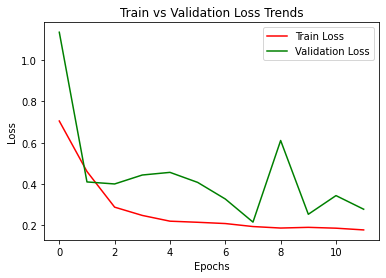

In [ ]:
# train and validation loss trends
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = [i for i in range(0, 12)]
plt.plot(epochs, train_loss, 'r', label='Train Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Train vs Validation Loss Trends')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

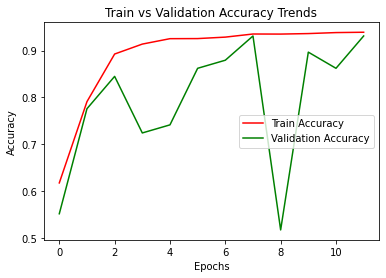

In [ ]:
# train and validation Accuracy trends
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = [i for i in range(0, 12)]
plt.plot(epochs, train_accuracy, 'r', label='Train Accuracy')
plt.plot(epochs, val_accuracy, 'g', label='Validation Accuracy')
plt.title('Train vs Validation Accuracy Trends')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Results

## Test Set

In [ ]:
predictions = alexnet.predict_classes(x_test)
predictions = predictions.reshape(1,-1)[0]

# confusion matrix
print('Confusion Matrix:\n', confusion_matrix(y_test, predictions), sep='')
print(f'Accuracy Score: {accuracy_score(y_test, predictions)*100}%')

Confusion Matrix:
[[1156   68]
 [  35 1241]]
Accuracy Score: 95.88%


In [ ]:
# detailed stats on models performance
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.97      0.94      0.96      1224
   Normal (Class 1)       0.95      0.97      0.96      1276

           accuracy                           0.96      2500
          macro avg       0.96      0.96      0.96      2500
       weighted avg       0.96      0.96      0.96      2500



## Train Set

In [ ]:
predictions = alexnet.predict_classes(x_train)
predictions = predictions.reshape(1,-1)[0]

# confusion matrix
print('Confusion Matrix:\n', confusion_matrix(y_train, predictions), sep='')
print(f'Accuracy Score: {accuracy_score(y_train, predictions)*100}%')

Confusion Matrix:
[[11748   782]
 [  314 12156]]
Accuracy Score: 95.616%


In [ ]:
# detailed stats on models performance
print(classification_report(y_train, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.97      0.94      0.96     12530
   Normal (Class 1)       0.94      0.97      0.96     12470

           accuracy                           0.96     25000
          macro avg       0.96      0.96      0.96     25000
       weighted avg       0.96      0.96      0.96     25000



# Saving The Model

In [ ]:
alexnet.save('./alexnet.h5', save_format='h5')

In [ ]:
# verifying saved model
model = tf.keras.models.load_model('./alexnet.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 23, 23, 96)        34944     
_________________________________________________________________
batch_normalization_5 (Batch (None, 23, 23, 96)        384       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 11, 11, 96)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 11, 11, 256)       614656    
_________________________________________________________________
batch_normalization_6 (Batch (None, 11, 11, 256)       1024      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 256)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 5, 5, 384)        